## Importing the needed libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

### NOTE: After running the function "maze_creator", one needs to check if the goal is reachable at all (by looking at the generated plot)

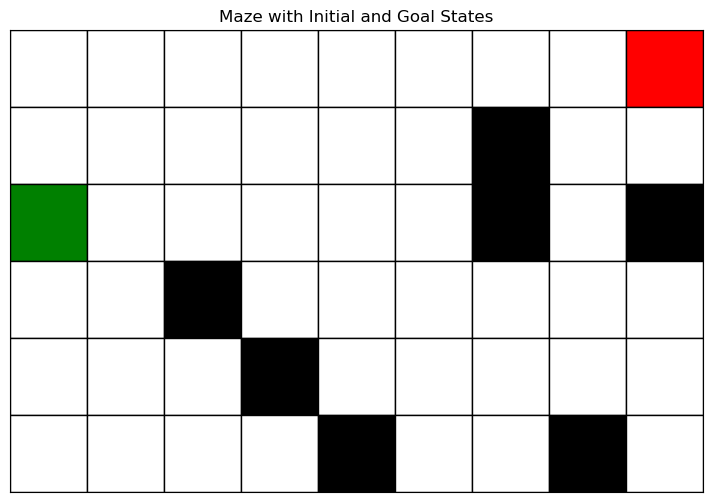

Maze Data:
{'maze': array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0]]), 'initial_state': (2, 0), 'goal_state': (0, 8), 'obstacles': [(4, 3), (5, 4), (5, 7), (2, 6), (1, 6), (3, 2), (2, 8)], 'rows': 6, 'cols': 9, 'actions': ['Right', 'Left', 'Up', 'Down']}


In [6]:
def maze_creator(rows, cols, num_obstacles, initial_state, goal_state, actions_list):
    """
    Create and visualize a maze, and return a structured representation of it.

    Parameters:
        rows (int): Number of rows in the maze.
        cols (int): Number of columns in the maze.
        num_obstacles (int): Number of obstacles to place in the maze.
        initial_state (tuple): Coordinates of the initial state (row, col).
        goal_state (tuple): Coordinates of the goal state (row, col).

    Returns:
        dict: A dictionary containing the maze grid and its metadata.
    """
    random.seed(2024)
    
    # Create a blank maze (0 for open spaces)
    maze = np.zeros((rows, cols), dtype=int)

    # Place the initial and goal states
    maze[initial_state] = 0  
    maze[goal_state] = 0  

    # Randomly place obstacles
    obstacle_positions = set()
    while len(obstacle_positions) < num_obstacles:
        obstacle = (random.randint(0, rows - 1), random.randint(0, cols - 1))
        if obstacle != initial_state and obstacle != goal_state:
            obstacle_positions.add(obstacle)

    for obs in obstacle_positions:
        maze[obs] = 1  # Mark obstacles as 1

    # Visualize the maze
    plt.figure(figsize=(cols, rows))
    for i in range(rows):
        for j in range(cols):
            if (i, j) == initial_state:
                color = 'green'
            elif (i, j) == goal_state:
                color = 'red'
            elif maze[i, j] == 1:
                color = 'black'  
            else:
                color = 'white' 

            # Draw each cell as a square
            plt.gca().add_patch(plt.Rectangle((j, rows - 1 - i), 1, 1, edgecolor='black', facecolor=color))

    # Set the plot limits and aspect ratio
    plt.xlim(0, cols)
    plt.ylim(0, rows)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.title("Maze with Initial and Goal States")
    plt.show()

    # Return the maze data
    return {
        "maze": maze,
        "initial_state": initial_state,
        "goal_state": goal_state,
        "obstacles": list(obstacle_positions),
        "rows": rows,
        "cols": cols,
        "actions": actions_list
    }


# Example usage
maze_data = maze_creator(
    rows=6,
    cols=9,
    num_obstacles=7,
    initial_state=(2, 0),
    goal_state=(0, 8),
    actions_list = ["Right", "Left", "Up", "Down"]
)

# Print the maze data
print("Maze Data:")
print(maze_data)

## Action performer function

In [7]:
def action_performer(state, action, maze_data):
    """
    Determine the resulting state based on the current state, action, and maze data.

    Parameters:
        state (int): The current state of the agent (0-indexed).
        action (str): The action to perform ('Right', 'Left', 'Up', 'Down').
        maze_data (dict): The data describing the maze created by maze_creator.

    Returns:
        int: The resulting state after performing the action.
    """
    rows, cols = maze_data['rows'], maze_data['cols']
    obstacles = set(maze_data['obstacles'])

    # Convert the 0-indexed state into row and column
    row, col = divmod(state, cols)

    # Determine the new position based on the action
    if action == "Right":
        new_row, new_col = row, col + 1
    elif action == "Left":
        new_row, new_col = row, col - 1
    elif action == "Up":
        new_row, new_col = row - 1, col
    elif action == "Down":
        new_row, new_col = row + 1, col
    else:
        raise ValueError(f"Invalid action: {action}")

    # Check if the new position is within the maze bounds
    if 0 <= new_row < rows and 0 <= new_col < cols:
        # Check if the new position is not an obstacle
        if (new_row, new_col) not in obstacles:
            # Convert the position back to 0-indexed state
            return new_row * cols + new_col

    # If the move is invalid (out of bounds or obstacle), return the original state
    return state

current_state = 33  # State (1, 0) in a 0-indexed maze
actions_list = ["Right", "Left", "Up", "Down"]

# Apply actions and print the results
for action in actions_list:
    new_state = action_performer(current_state, action, maze_data)
    print(f"Action: {action}, New State: {new_state}")

Action: Right, New State: 34
Action: Left, New State: 32
Action: Up, New State: 33
Action: Down, New State: 42


In [8]:
def generate_random_start(maze_data):
    rows = maze_data["rows"]
    cols = maze_data["cols"]
    actions = maze_data["actions"]
    obstacles = maze_data["obstacles"]
    goal_state = maze_data["goal_state"]
    
    while True:
        # Randomly pick a state
        state = random.randint(0, rows * cols - 1)
        row, col = divmod(state, cols)  # Convert state to (row, col)
        
        # Skip if the state is the goal state or an obstacle
        if (row, col) == goal_state or (row, col) in obstacles:
            continue
        
        break
    return state

In [9]:
def update_policy(maze_data, state_action_values, policy, state, epsilon):
    
    action_space = len(maze_data['actions'])
    epsilon_value = epsilon/action_space
    
    max_value = max(state_action_values[state].values())
    max_actions = [act for act, val in state_action_values[state].items() if val == max_value]
                
    num_max_actions = len(max_actions)
    if num_max_actions == action_space:
        return
    
    j = 0
    for act in policy[state]:
        if act in max_actions:
            policy[state][act] = 1 / num_max_actions + epsilon_value # Equal probability for tied actions
            if j == 0:
                policy[state][act] -= epsilon
                j = 1
        else:
            policy[state][act] = epsilon_value
    
    return

In [13]:
def action_picker(maze_data, policy, state):
    actions = maze_data["actions"]
    action_probabilities = list(policy[state].values())
    next_action = random.choices(actions, weights=action_probabilities, k=1)[0]
    return next_action

In [61]:
def sarsa_control(maze_data, alpha_0, gamma_0, epsilon):
    
    rows = maze_data["rows"]
    cols = maze_data["cols"]
    actions = maze_data["actions"]
    obstacles = maze_data["obstacles"]
    goal_state = maze_data["goal_state"]
    
    # Initialize
    # Take equal probabilities for each action
    # Take all state action values to be 0 initially
    initial_action_probabilties = 1/len(actions)
    
    policy = {}
    state_action_values = {}
    state_action_visits = {}
    
    for i in range(rows*cols):
        temp_dict_policy = {}
        temp_dict_action_values = {}
        temp_dict_action_visits = {}
        
        for j in actions:
            temp_dict_policy[j] = initial_action_probabilties
            temp_dict_action_values[j] = 0
            temp_dict_action_visits[j] = 0
        
        policy[i] = temp_dict_policy
        state_action_values[i] = temp_dict_action_values
        state_action_visits[i] = temp_dict_action_visits
        
        
    k = 0
    # Episodes
    while True:
        k = k+1
        state = generate_random_start(maze_data)
        action = action_picker(maze_data, policy, state)
#         print(state,action)
        # Until Terminal
        l = 0
        while True:
            l = l + 1
            new_state = action_performer(state, action, maze_data)
            new_action = action_picker(maze_data, policy, new_state)
            
            if divmod(new_state, cols) == goal_state:
                R = 1
            else:
                R = 0
            
            old = state_action_values[state][action]
            state_action_values[state][action] = old + alpha_0*(R + gamma_0* state_action_values[new_state][new_action] - old)
            update_policy(maze_data, state_action_values, policy, state, epsilon)
            
            if divmod(new_state, cols) == goal_state:
                break
            
            state = new_state
            action = new_action
            
            if l > 10000:
                break
        
        
        if k > 10000:
            break
            
    return policy, state_action_values

policy_1, state_action_values_1 = sarsa_control(maze_data, 0.5, 0.9, 0.1)

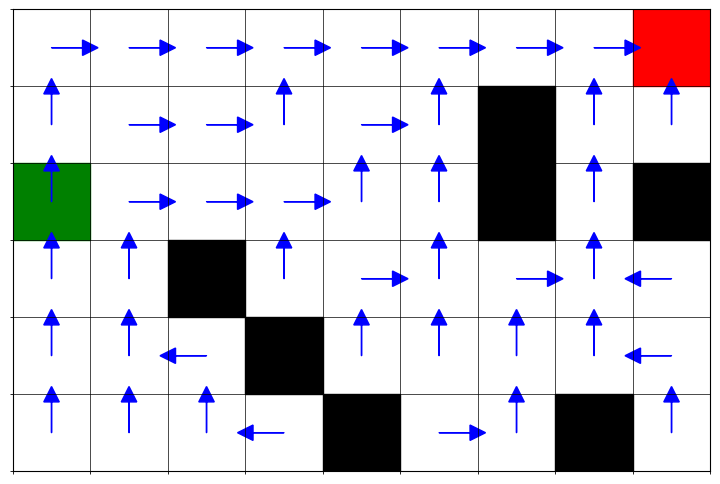

In [51]:
def plot_policy(policy, maze_data):
    rows = maze_data["rows"]
    cols = maze_data["cols"]
    obstacles = maze_data["obstacles"]
    goal_state = maze_data["goal_state"]  # Now as (row, col)
    initial_state = maze_data["initial_state"]  # Now as (row, col)

    # Create a grid
    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(-0.5, rows - 0.5)
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

    # Draw obstacles
    for obstacle in obstacles:
        ax.add_patch(plt.Rectangle((obstacle[1] - 0.5, rows - obstacle[0] - 1.5), 1, 1, color="black"))
    
    # Mark the initial state in green
    ax.add_patch(plt.Rectangle((initial_state[1] - 0.5, rows - initial_state[0] - 1.5), 1, 1, color="green"))
    
    # Mark the goal state in red
    ax.add_patch(plt.Rectangle((goal_state[1] - 0.5, rows - goal_state[0] - 1.5), 1, 1, color="red"))

    # Define arrow directions
    arrow_mapping = {
        "Right": (0.4, 0),  # Move right
        "Left": (-0.4, 0),  # Move left
        "Up": (0, 0.4),     # Move up
        "Down": (0, -0.4),  # Move down
    }

    # Add arrows for each cell
    for state, actions in policy.items():
        row, col = divmod(state, cols)
        cell = (row, col)  # Convert state to tuple for comparison
        if cell in obstacles or cell == goal_state:
            continue  # Skip obstacles, goal state, and initial state

        # Find the action(s) with max probability
        max_prob = max(actions.values())
        max_actions = [action for action, prob in actions.items() if prob == max_prob]

        for action in max_actions:
            dx, dy = arrow_mapping[action]
            ax.arrow(
                col, rows - row - 1, dx, dy,
                head_width=0.2, head_length=0.2, fc="blue", ec="blue"
            )

    plt.show()

plot_policy(policy_1, maze_data)

In [60]:
def q_control(maze_data, alpha_0, gamma_0, epsilon):
    
    rows = maze_data["rows"]
    cols = maze_data["cols"]
    actions = maze_data["actions"]
    obstacles = maze_data["obstacles"]
    goal_state = maze_data["goal_state"]
    
    # Initialize
    # Take equal probabilities for each action
    # Take all state action values to be 0 initially
    initial_action_probabilties = 1/len(actions)
    
    policy = {}
    state_action_values = {}
    state_action_visits = {}
    
    for i in range(rows*cols):
        temp_dict_policy = {}
        temp_dict_action_values = {}
        temp_dict_action_visits = {}
        
        for j in actions:
            temp_dict_policy[j] = initial_action_probabilties
            temp_dict_action_values[j] = 0
            temp_dict_action_visits[j] = 0
        
        policy[i] = temp_dict_policy
        state_action_values[i] = temp_dict_action_values
        state_action_visits[i] = temp_dict_action_visits
        
        
    k = 0
    # Episodes
    while True:
        k = k+1
        state = generate_random_start(maze_data)
        action = action_picker(maze_data, policy, state)
#         print(state,action)
        # Until Terminal
        l = 0
        while True:
            l = l + 1
            new_state = action_performer(state, action, maze_data)
            new_action = action_picker(maze_data, policy, new_state)
            max_new_state_value = max(state_action_values[new_state].values())
            
            if divmod(new_state, cols) == goal_state:
                R = 1
            else:
                R = 0
            
            old = state_action_values[state][action]
            state_action_values[state][action] = old + alpha_0*(R + gamma_0* max_new_state_value - old)
#             update_policy(maze_data, state_action_values, policy, state, epsilon)
            
            if divmod(new_state, cols) == goal_state:
                break
            
            state = new_state
            action = new_action
            
            if l > 10000:
                break
        
        
        if k > 10000:
            break
            
    return policy, state_action_values

policy_2, state_action_values_2 = q_control(maze_data, 0.5, 0.9, 0.1)

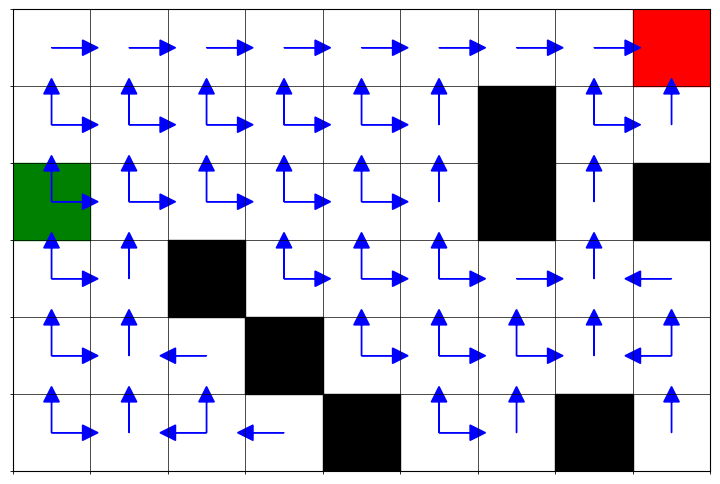

In [59]:
def getting_policy_for_q(maze_data, state_action_values):
    rows = maze_data["rows"]
    cols = maze_data["cols"]
    actions = maze_data["actions"]
    obstacles = maze_data["obstacles"]
    goal_state = maze_data["goal_state"]
    
    # Initialize
    # Take equal probabilities for each action
    # Take all state action values to be 0 initially
    initial_action_probabilties = 1/len(actions)
    
    policy = {}
    
    for i in range(rows*cols):
        temp_dict_policy = {}
        
        for j in actions:
            temp_dict_policy[j] = initial_action_probabilties

        
        policy[i] = temp_dict_policy
    
    for state in state_action_values.keys():
        max_value = max(state_action_values[state].values())
        max_actions = [act for act, val in state_action_values[state].items() if val == max_value]

                    # Update the policy: distribute probability equally among all max actions
        num_max_actions = len(max_actions)
        for act in policy[state]:
            var = policy[state][act]
            if act in max_actions:
                policy[state][act] = 1 / num_max_actions  # Equal probability for tied actions
            else:
                policy[state][act] = 0
    
    return policy
policy_2 = getting_policy_for_q(maze_data,state_action_values_2)
plot_policy(policy_2, maze_data)